# ASR Assignment 2022-23

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2022-23/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/ZhaoZeyu1995/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


In [22]:
import glob
import os
import wer
import observation_model
import openfst_python as fst
import math

import importlib
import fst_graph
from fst_graph import *
importlib.reload(fst_graph)

<module 'fst_graph' from '/afs/inf.ed.ac.uk/user/s26/s2653879/Documents/ASR/asr_assignment/fst_graph.py'>

In [23]:
def add_to_file(file: str, txt: str):
    f = open(file, 'a')
    f.write(txt)
    f.close()

In [24]:
class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is not really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()
    
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []
        self.B = [] # B[t][i]
        self.W = []
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append(['']*self.f.num_states())
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        start_state = self.f.start()
        N = len(lex)
        for arc in self.f.arcs(start_state):
            s = arc.nextstate
            self.V[0][s] = -math.log(1/N)

        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """

        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
#                         print(tp, ep, self.V[t-1][i])
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            olbl = arc.olabel
                            olbl = self.f.output_symbols().find(olbl)
                            self.W[t][j] = olbl
    
    def finalise_decoding(self):
        
        # TODO - exercise
        states = list(range(self.f.num_states()))
        for i in states:
            prob_final = float(self.f.final(i)) # probablity of being the end state (0 for non finals, and upwards of 1 if one final state, or split between all final states)
            if (self.V[-1][i] < self.NLL_ZERO):
                if (prob_final == math.inf): # not a final state
                    self.V[-1][i] = self.NLL_ZERO
                else: # is a final state
                    self.V[-1][i] += prob_final # includes the weighting of ending at each of the final states in the path towards them in the last step
        
    def decode(self):
        
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.traverse_epsilon_arcs(t)
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        
        self.finalise_decoding()
    
    def backtrace(self):
        T = self.om.observation_length()
        current = -1
        for i in range(self.f.num_states()):
            if (float(self.f.final(i)) != math.inf): # if i is final
                if (self.B[T][i] != -1):
                    if (current == -1):
                        current = i
                    elif (self.V[-1][current] > self.V[-1][i]):
                        current = i
        if (current == -1):
            raise Exception('No valid path')
        seq = [current]
        currentStr = ''
        strSeq = ''
        
        for t in range(T,-1, -1):
            tmpStr = self.W[t][current]
            if not(tmpStr in ['', '<eps>']):
                currentStr = tmpStr
                strSeq = f'{currentStr} {strSeq}'
        
       
            current = self.B[t][current]
            seq.insert(0, current)
        
        
        strSeq = strSeq.strip()
        best_state_sequence = (seq, strSeq)
        
        return best_state_sequence

In [28]:
def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription

def run(is_copy=True):
    f = create_wfst()
    
    files = list(glob.glob('/group/teaching/asr/labs/recordings/*.wav'))
    
    if (is_copy):
        # copy to prev
        with open('results_prev.txt', 'w') as file:
            with open('results.txt', 'r') as file2:
                file.write(file2.read())
        with open('wer_data_prev.txt', 'w') as file:
            with open('wer_data.txt', 'r') as file2:
                file.write(file2.read())
    
    # clear results file
    with open('results.txt', 'w') as file:
        pass
    # clear results file
    with open('wer_data.txt', 'w') as file:
        pass

    # 10:15
    # 37:42
    start = 10
    end = 15

#     start = 37
#     end = 42

#     start = 0
#     end = len(files)

    counter = start
    for wav_file in files[start:end]:
#     for wav_file in files:    # replace path if using your own audio files
        decoder = MyViterbiDecoder(f, wav_file)
        
        decoder.decode()
#         print(decoder.V)
#         input()
        (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                                   # to return the words along the best path


        transcription = read_transcription(wav_file)
        text = (f"\n\n{state_path}\n\n[{words}]\n[{transcription}]")
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())

        res = f'{error_counts} {word_count}\n'     # you'll need to accumulate these to produce an overall Word Error Rate
        print(f'{counter}\n{words}\n{transcription}\n{res}')
        add_to_file('results.txt', f'{text}\n{res}')
        add_to_file('wer_data.txt', res)
        
        counter += 1

In [27]:
%%timeit -r 1 -n 1
run(True)
# run(False)

pickled peter piper the peck a the peck of pickled peppers where's the peck of pickled peppers peter piper picked a
peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
(1, 0, 4) 17

pickled a peter picked the of peck of pickled peppers a
peter picked a peck of pickled peppers
(1, 0, 4) 7

pickled the peck of pickled peppers picked a
a peck of pickled peppers picked
(1, 0, 2) 6

pickled peter piper peter piper a
peter piper peter piper
(0, 0, 2) 4

pickled where's the pickled pickled peppers picked a
where's the peck of pickled peppers picked
(1, 1, 2) 7

peck peter piper peck pickled peppers a
peter piper pickled peppers
(0, 0, 3) 4

where's peter a
where's peter
(0, 0, 1) 2

a piper peck picked peppers of peter a
piper picked peppers of peter
(0, 0, 3) 5

peter peppers picked piper of peck a
peter peppers picked piper of peck
(0, 0, 1) 6

a picked peck of picked peppers peter piper pickled a
a peck of pickled peppers peter piper pickled


a of peck of the pickled peppers peter piper picked a
a peck of the pickled peppers peter piper picked
(0, 0, 2) 9

a piper picked the peter of the peck a
piper picked peter of the peck
(0, 0, 3) 6

a peck peter picked peck of picked pickled piper a
a peter picked peck of picked pickled piper
(0, 0, 2) 8

a where's peck peppers of piper a
where's peck peppers of piper
(0, 0, 2) 5

a piper pickled picked where's a
piper of peppers
(2, 0, 3) 3

a peter picked picked piper a a
peter picked piper
(0, 0, 4) 3

pickled peppers peter of piper picked a
where's the peck of pickled peppers peter piper picked
(0, 4, 2) 9

peck of pickled peppers picked of peck of pickled peck where's a
the peck of pickled peppers picked a peck of pickled peppers
(2, 1, 2) 11

peter of piper where's of peck of pickled piper where's peter piper a
peter piper where's the peck of pickled peppers
(2, 0, 5) 8

peter the piper peter of piper of picked of pickled peck where's a
peter piper peter piper a peck of pickled p

a pickled piper picked of peck of pickled peck peck of a
peter piper picked a peck of pickled peppers
(3, 0, 4) 8

a peppers the peck of pickled peck peppers peter piper of picked a
where's the peck of pickled peppers peter piper picked
(1, 0, 4) 9

a a of piper of picked of picked of pickled piper where's a
peter piper picked a peck of pickled peppers
(4, 0, 5) 8

a where's of piper of pickled piper where's peter piper of the a
where's the peck of pickled peppers peter piper picked
(4, 0, 4) 9

a piper of pickled piper where's picked of piper of the a
peck of pickled peppers peter piper picked
(4, 0, 5) 7

a peter of piper of picked of piper of pickled piper where's a
peter piper picked a peck of pickled peppers
(3, 0, 5) 8

a peter of piper pickled pickled pickled piper where's a
peter piper picked pickled peppers
(2, 0, 5) 5

a picked of picked picked picked a
peter piper picked
(2, 0, 4) 3

a the of piper picked of picked of pickled the peppers a
peter piper picked a peck of pickle

a pickled piper of a where's a pickled the the of of piper where's peter piper where's pickled the of piper a a
a peck of peppers pickled picked peter piper where's peter piper peppers pickled the peck picked
(7, 0, 7) 16

a pickled where's of peter picked of piper piper picked the pickled picked a
peter where's a peter picked of piper piper peck pickled picked
(3, 0, 3) 11

a pickled peter pickled of peck a
pickled peter pickled of peck
(0, 0, 2) 5

a where's the of where's piper the of peck of peter picked the pickled of pickled piper picked a
peppers peppers piper the peck peter picked pickled of pickled piper picked
(2, 0, 7) 12

a where's the of piper of pickled peter peter of piper of picked a
where's the peck of pickled peppers peter piper picked
(2, 0, 5) 9

a peck of piper pickled peter pickled pickled of peck peter peck picked piper where's of where's peter pickled peppers picked a
peck a piper pickled peter of of the peck peter picked piper where's peppers pickled peppers pi

a of peppers pickled of peck picked peter a
peppers pickled a peck picked peter
(1, 0, 3) 6

a picked where's picked peppers a
peter picked peppers
(1, 0, 3) 3

a picked of pickled peck where's a
peck of pickled peppers
(2, 0, 3) 4

a where's a of piper a
where's peter piper
(1, 0, 3) 3

a pickled peck of peppers a
pickled peck of peppers
(0, 0, 2) 4

a where's piper a the peck peck a
peter piper picked a peck
(1, 1, 4) 5

a peter where's of piper peck peter a
peppers of piper peck peter
(1, 0, 3) 5

a peter of piper of picked of a
peter a piper of a peck
(3, 0, 2) 6

a peck pickled peter of peck a
peck pickled peter peck
(0, 0, 3) 4

a a piper of peter peck of where's of pickled peter a
a piper of peter picked peppers of pickled peter
(2, 0, 3) 9

a of peck picked peter of pickled a
of peck a peter pickled
(1, 0, 3) 5

piper picked picked of peck of the peppers a
piper picked a peck of the peppers
(1, 0, 2) 7

a where's peter of piper a
where's peter piper
(0, 0, 3) 3

pickled peppers

In [ ]:
file = open('wer_data.txt', 'r')
wer_counts = file.read()
file.close()
S, D, I, N = 0, 0, 0, 0
wer_counts = wer_counts.strip().split("\n")
IndexCount = len(wer_counts)
for wer_elem in wer_counts:
    wer_elem = wer_elem.replace("(", "").replace(")", "").replace(",", "").split(" ")
    S += int(wer_elem[0])
    D += int(wer_elem[1])
    I += int(wer_elem[2])
    N += int(wer_elem[3])

WER = (S + D + I) / N
print(IndexCount, WER, S, D, I, N)

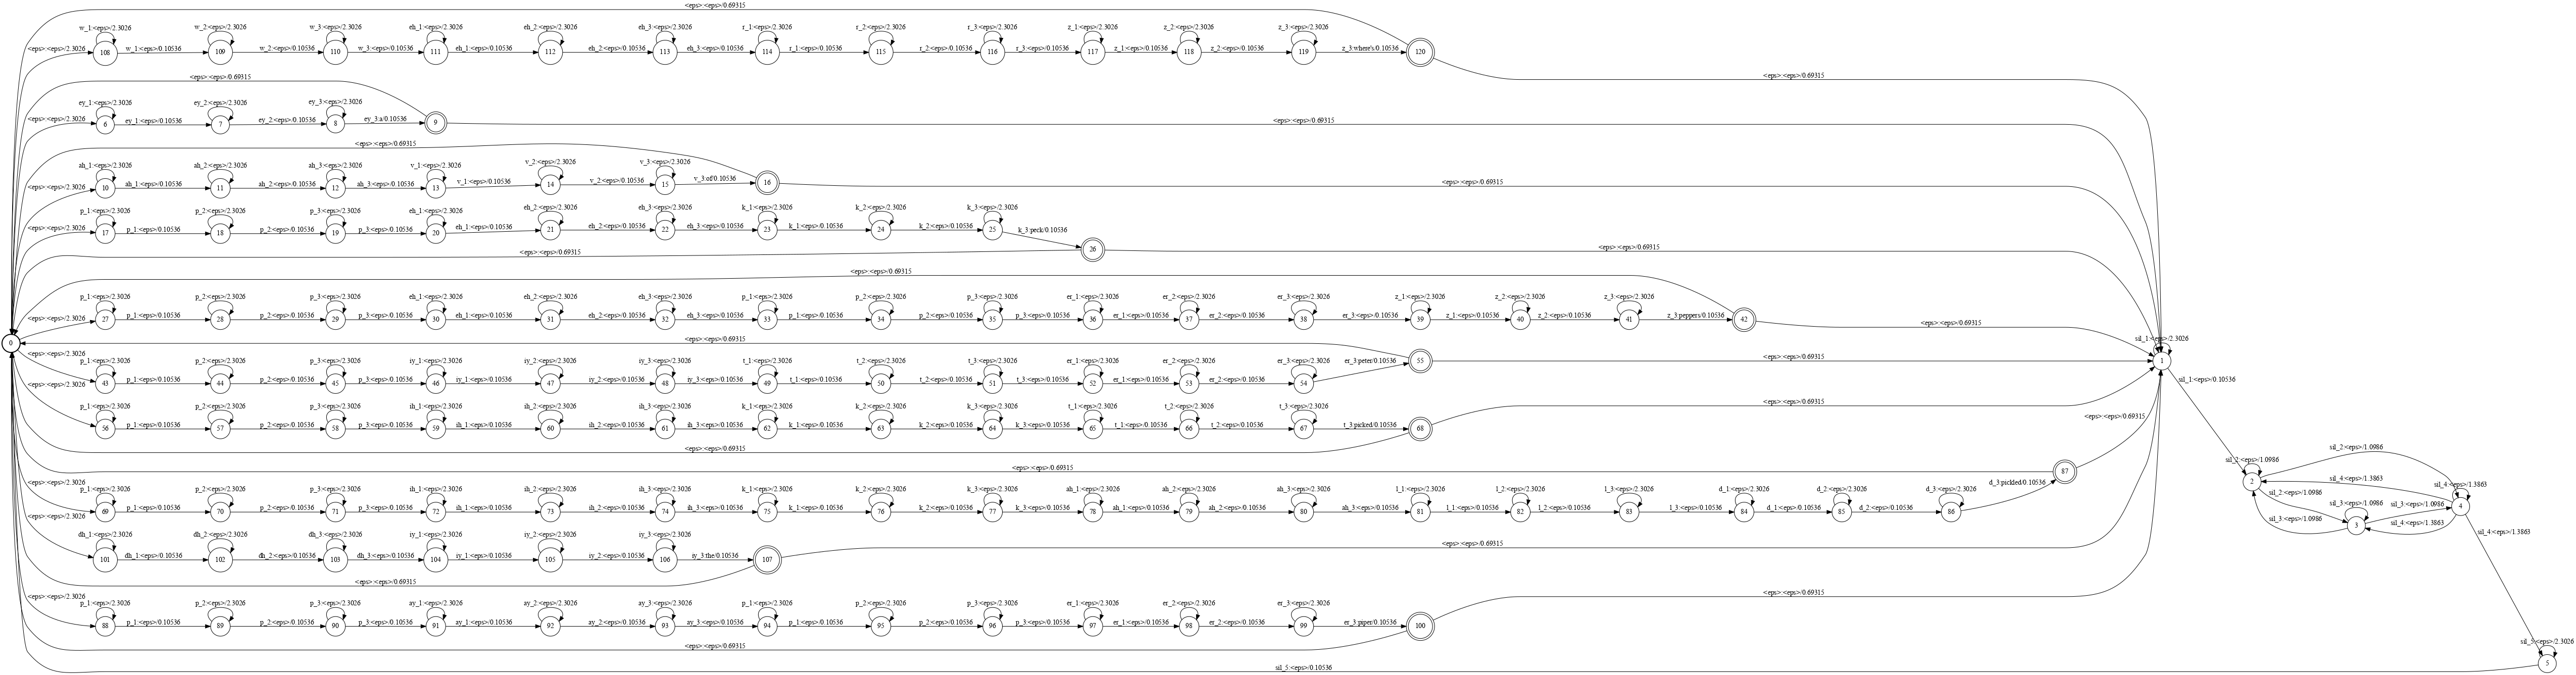

In [21]:
f = create_wfst()
draw_f(f)